### Data Loading and Preprocessing 

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random

2024-11-18 14:58:07.412973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 14:58:07.428300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 14:58:07.433035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 14:58:07.444616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 14:58:08.086230: W tensorflow/compiler/tf2

In [3]:
# Defining the paths for the train and test directories
train_dir = '../FER_2013_dataset/train'
test_dir = '../FER_2013_dataset/test'

# Defining the emotion classes based on the folder names
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

#A function to show random images
def show_random_images(X_train, y_train, emotion_classes, num_images=20):
    # Set the number of rows and columns for the plot grid
    rows, cols = 4, 5  # 4x5 grid to show 20 images
    plt.figure(figsize=(15, 10))

    # Randomly sample indices for the images to display
    random_indices = random.sample(range(len(X_train)), num_images)
    
    for i, idx in enumerate(random_indices):
        img = X_train[idx]
        label = y_train[idx]

        # Display image in the grid
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray') 
        plt.title(f"Label: {emotion_classes[label]}")
        plt.axis('off') 
    
    plt.tight_layout()
    plt.show()


### Function for data augmentation

In [11]:
# Function to load and augment images from a directory to balance classes
def load_data_with_augmentation(data_dir, emotion_classes, img_size=(48, 48), target_count=1000,augmentation=True):
    images = []
    labels = []
    each_class_image_numbers=[]
    augmented_images=[]
    augmented_labels=[]
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for emotion_label, emotion_name in enumerate(emotion_classes):
        emotion_folder = os.path.join(data_dir, emotion_name)
        total_images = 0

        # Load images
        for idx, img_filename in enumerate(os.listdir(emotion_folder)):
            if idx>5000: #skipping sample data
                break
            img_path = os.path.join(emotion_folder, img_filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, img_size)
                img_normalized = img_resized / 255.0
                images.append(img_normalized)
                labels.append(emotion_label)
                total_images += 1

        if(augmentation):
            # Augment if below target count
            if total_images < target_count:
                diff = target_count - total_images
                # Load images in grayscale and add channel dimension for compatibility
                img_data = np.array([cv2.resize(cv2.imread(os.path.join(emotion_folder, img), cv2.IMREAD_GRAYSCALE), img_size) / 255.0 
                                    for img in os.listdir(emotion_folder) if img is not None])

                # Reshape to (images, 48, 48, 1) to add a channel dimension for grayscale
                img_data = np.expand_dims(img_data, axis=-1)
        
                for x in datagen.flow(img_data, batch_size=1):
                    if total_images >= target_count:
                        break
                    images.append(x[0].reshape(img_size))
                    labels.append(emotion_label)
                    augmented_images.append(x[0].reshape(img_size))
                    augmented_labels.append(emotion_label)
                    total_images += 1
                
        print(f"Total images in {emotion_name} after augmentation: {total_images}")
        each_class_image_numbers.append(total_images)

    return np.array(images), np.array(labels),np.array(augmented_images),np.array(augmented_labels),each_class_image_numbers

Loading training images from the dataset and assigning each image its corresponding class label.

In [12]:
# Example usage
X_train, y_train,augmented_images,augmented_labels,each_class_image_numbers = load_data_with_augmentation(train_dir, emotion_classes, target_count=4101,augmentation=True)
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)

Total images in angry after augmentation: 4101
Total images in disgust after augmentation: 4101
Total images in fear after augmentation: 4101
Total images in happy after augmentation: 5001
Total images in sad after augmentation: 4830
Total images in surprise after augmentation: 4101
Total images in neutral after augmentation: 4964
X_train shape: (31199, 48, 48)
y_train shape: (31199,)


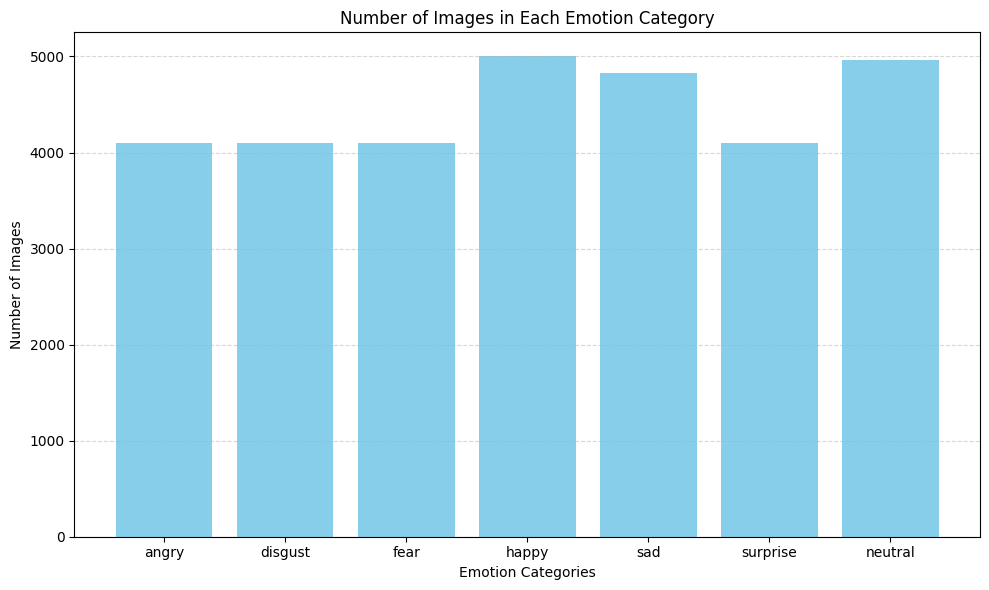

In [14]:
# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotion_classes, each_class_image_numbers, color='skyblue')

# Adding title and labels
plt.title('Number of Images in Each Emotion Category')
plt.xlabel('Emotion Categories')
plt.ylabel('Number of Images')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()


### Showing training images

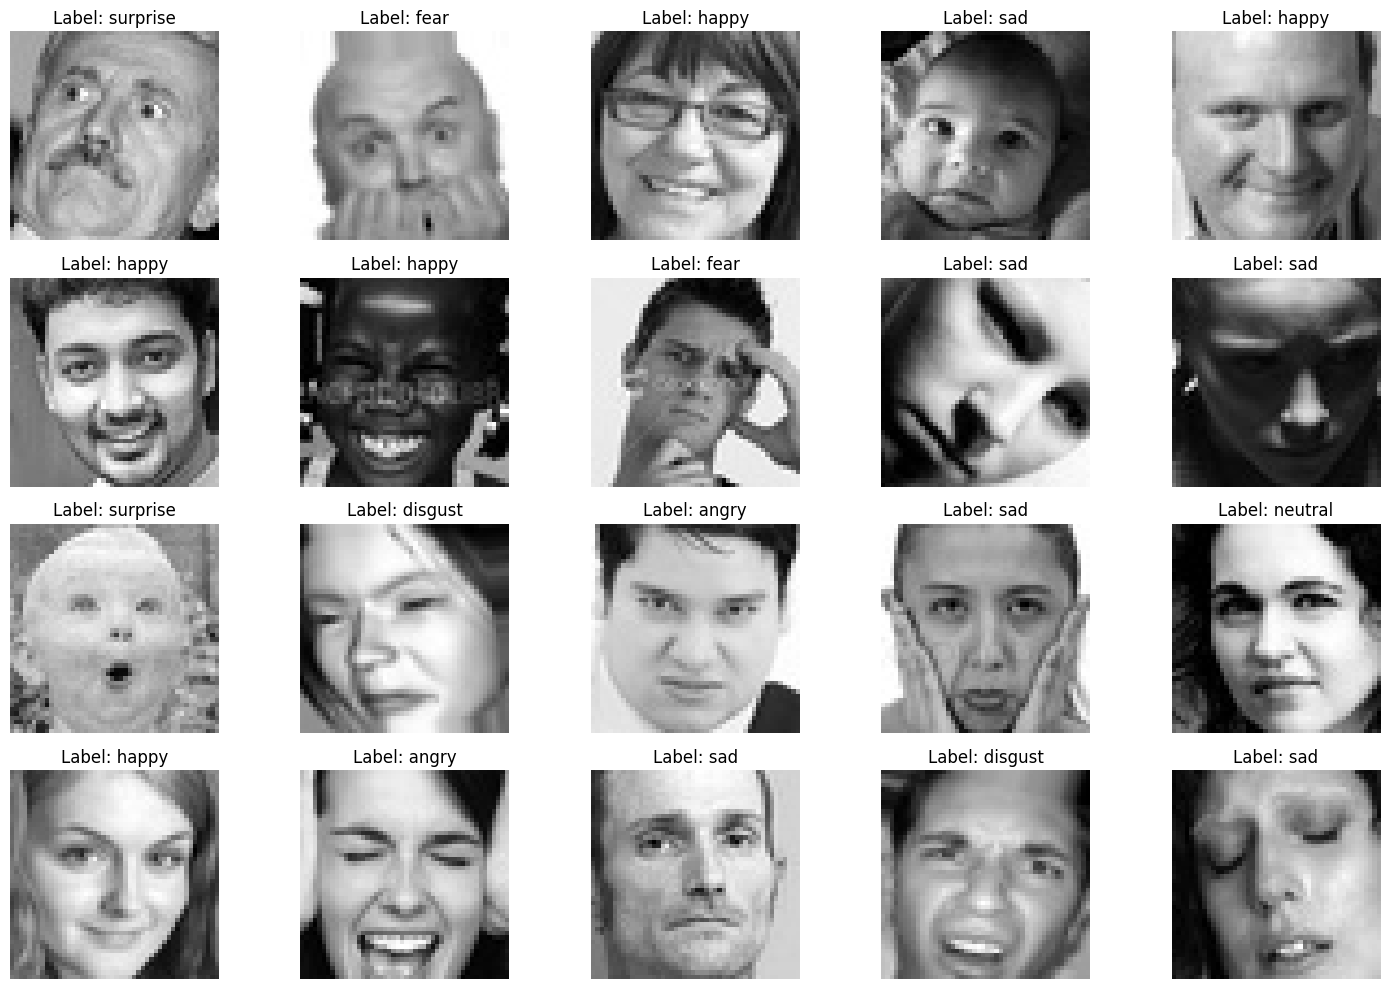

In [15]:
# Showing random images from training data
show_random_images(X_train, y_train, emotion_classes)

### Showing Augmented Images 

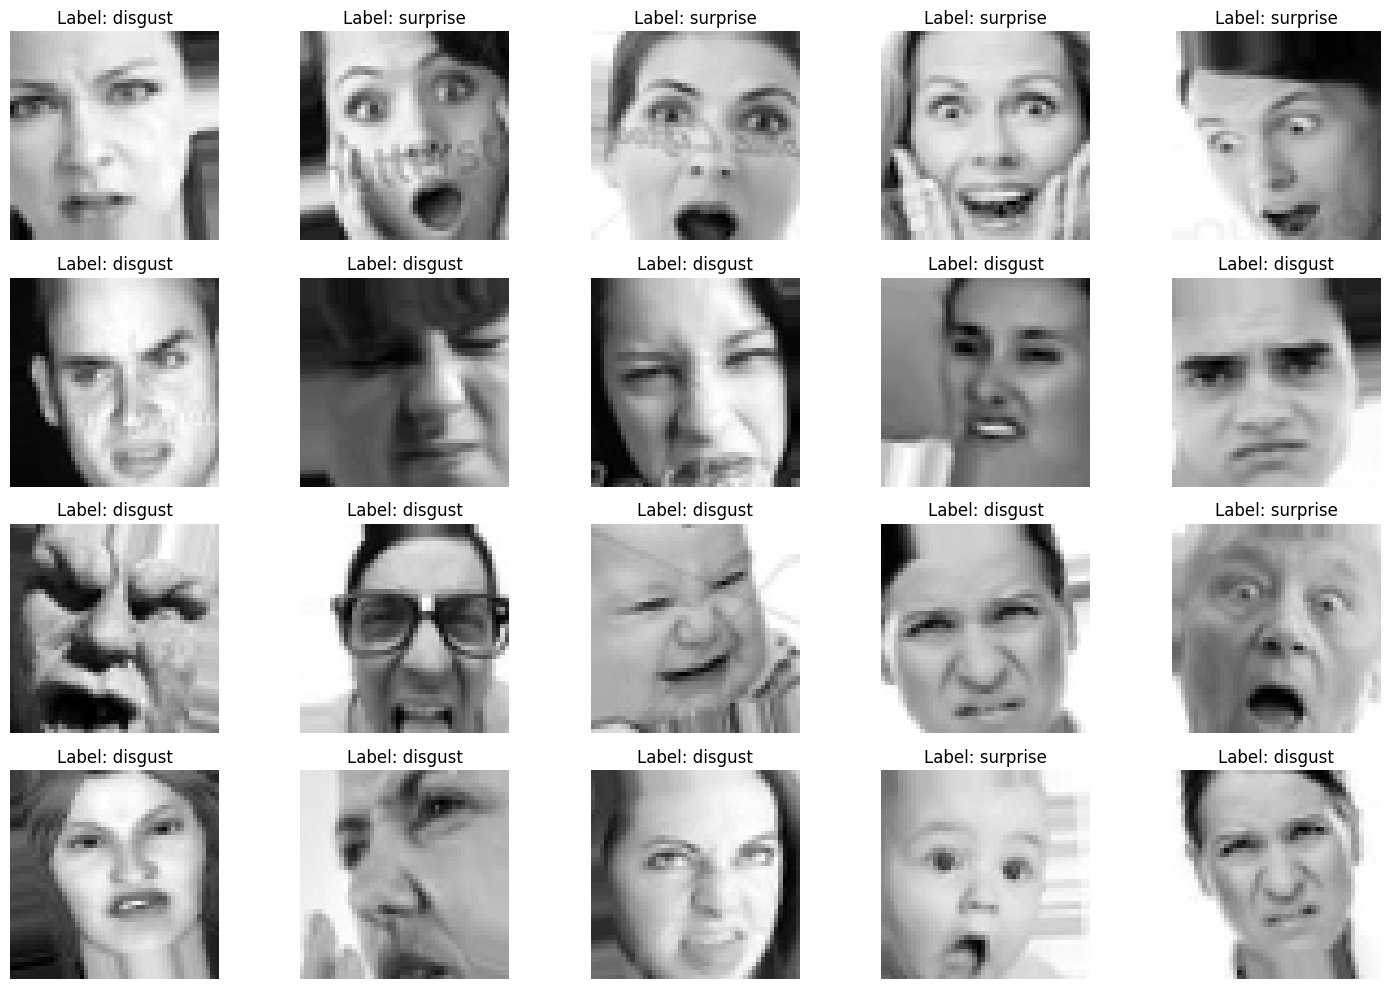

In [16]:
# Showing random augmented images from training data
show_random_images(augmented_images, augmented_labels, emotion_classes)

Loading testing images from the dataset and assigning each image its corresponding class label.

In [17]:
# Example usage
X_test, y_test,augmented_images,augmented_labels,each_class_image_numbers = load_data_with_augmentation(test_dir, emotion_classes, target_count=1000,augmentation=False)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

Total images in angry after augmentation: 958
Total images in disgust after augmentation: 111
Total images in fear after augmentation: 1024
Total images in happy after augmentation: 1774
Total images in sad after augmentation: 1247
Total images in surprise after augmentation: 831


Total images in neutral after augmentation: 1233
X_test shape: (7178, 48, 48)
y_test shape: (7178,)


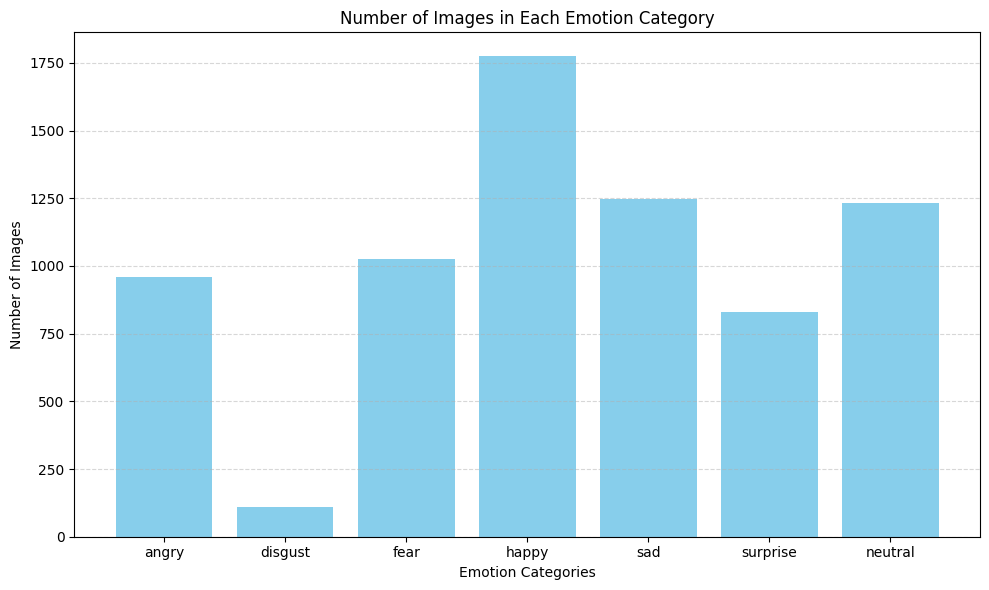

In [18]:
# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotion_classes, each_class_image_numbers, color='skyblue')

# Adding title and labels
plt.title('Number of Images in Each Emotion Category')
plt.xlabel('Emotion Categories')
plt.ylabel('Number of Images')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

### Showing test images

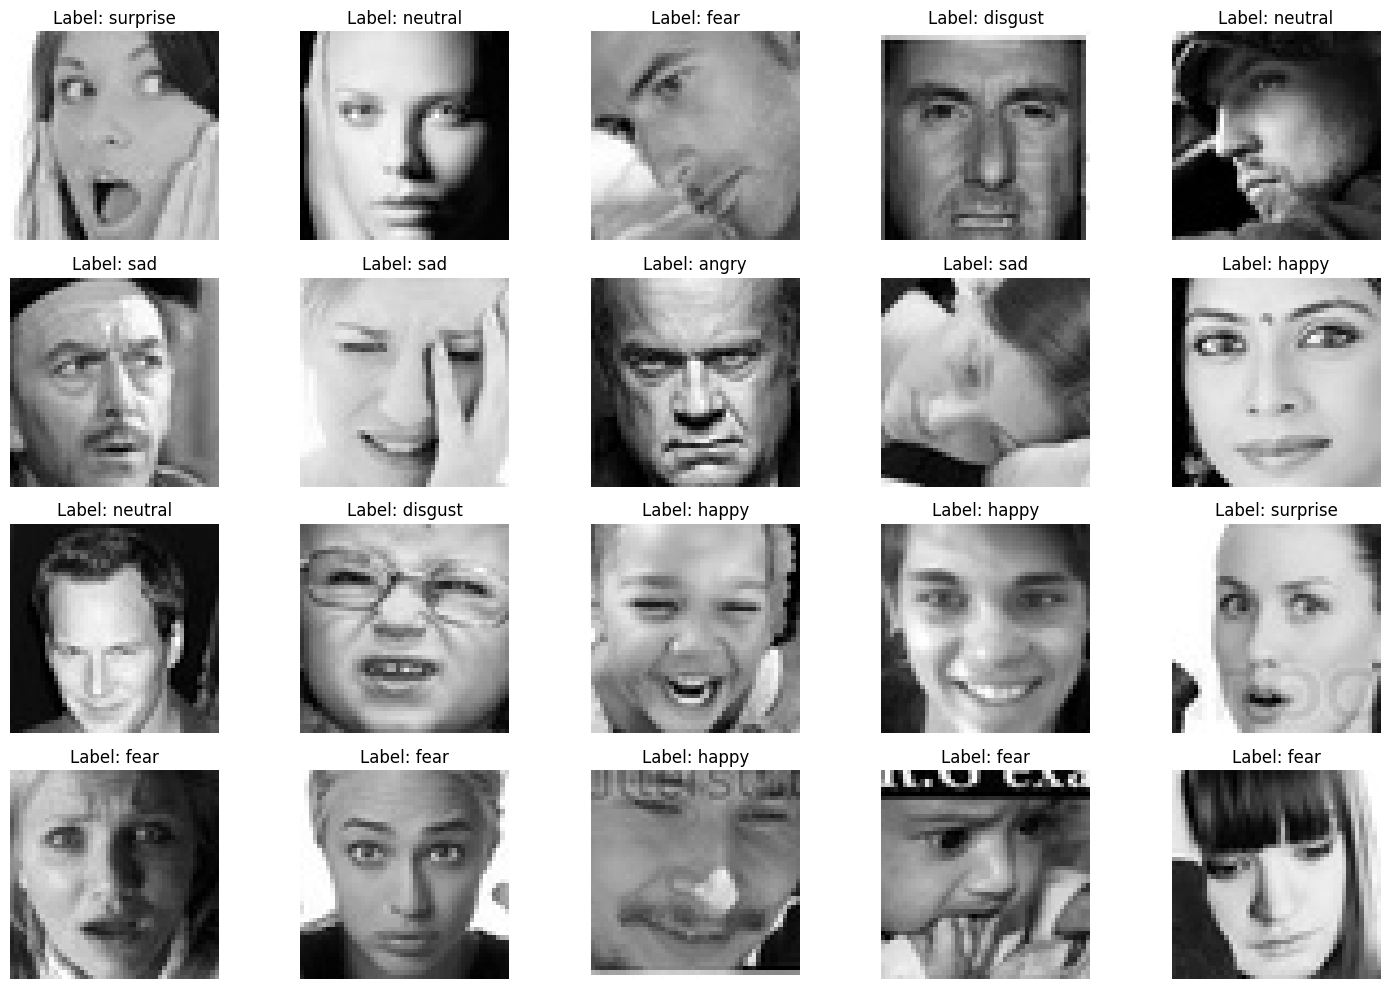

In [19]:
# Showing random images from testing data
show_random_images(X_test, y_test, emotion_classes)

###  Showing testing augmented images

In [20]:
# Showing random augmented images from training data
if(len(augmented_images)):
    show_random_images(augmented_images, augmented_labels, emotion_classes)
else:
    print("Data augmentation was not performed!!")

Data augmentation was not performed!!


### Randomizing the training dataset.

In [21]:
import random

# Zip the lists together and convert to a list of tuples
combined = list(zip(X_train, y_train))

# Shuffle the combined list
random.shuffle(combined)

# Unzip back into separate lists
X_train, y_train = zip(*combined)

# Convert back to lists if needed
X_train_shuffled = np.array(list(X_train))
y_train_shuffled = np.array(list(y_train))

### Flattening the training and test data to feed into the model.

In [22]:
# Flattening the training data
X_train_flat = X_train_shuffled.reshape(X_train_shuffled.shape[0], -1)

#Flattening the testing data
X_test_flat = X_test.reshape(X_test.shape[0], -1)

#Printing the shape of all the lists
print("Shape of X_train_shuffled :",X_train_shuffled.shape)
print("Shape of X_train_flat :",X_train_flat.shape)
print("Shape of y_train_shuffled :",y_train_shuffled.shape)
print("Shape of X_test :",X_test.shape)
print("Shape of X_test_flat :",X_test_flat.shape)
print("Shape of y_test :",y_test.shape)

Shape of X_train_shuffled : (31199, 48, 48)
Shape of X_train_flat : (31199, 2304)
Shape of y_train_shuffled : (31199,)
Shape of X_test : (7178, 48, 48)
Shape of X_test_flat : (7178, 2304)
Shape of y_test : (7178,)


In [23]:
#Reinitializing all the variables to ensure consistency in code.
X_train=X_train_flat
y_train=y_train_shuffled
X_test=X_test_flat
y_test=y_test

#------------------------------
# Create and train the SVM model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(n_estimators=50,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, random_state=42)

## Applying PCA to the training and test data.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the flattened training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Check the new shape after PCA
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

# Apply PCA
pca = PCA(n_components=25)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check the new shape after PCA
print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)

# You can now train your model on X_train_pca and evaluate it on X_test_pca


NameError: name 'X_train_flat' is not defined

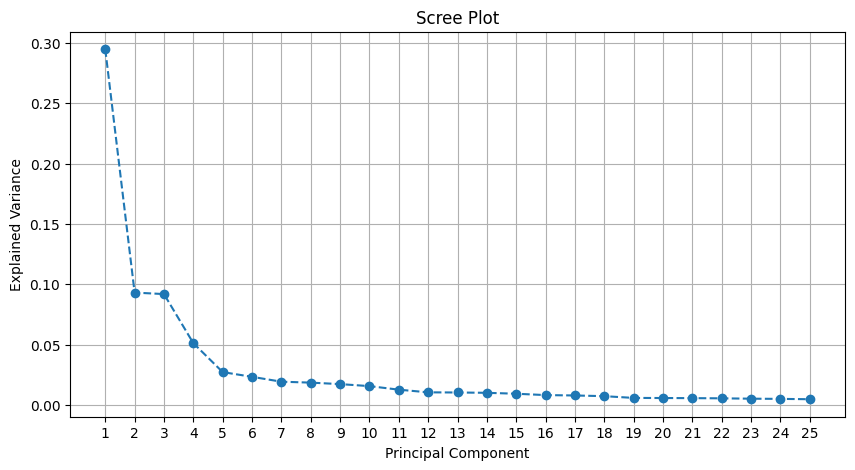

In [ ]:
import matplotlib.pyplot as plt

# Assuming pca is your PCA object and you have fit it to the data
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()


In [ ]:
X_train=X_train_pca
y_train=y_train_shuffled
X_test=X_test_pca
y_test=y_test

#Ready to feed the training data(PCA-applied) to the model
#Create to model belowed section

In [ ]:
# Create and train the SVM model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(n_estimators=50,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42)

model.fit(X_train, y_train)


Training Accuracy: 44.47%
Testing Accuracy: 34.87%
